In [1]:
pip install git+https://github.com/forrestbao/pyeeg.git

  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-yiyv52wz
  Running command git clone -q https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-yiyv52wz


In [2]:
import numpy as np
import pickle as pickle
import pandas as pd
import pyeeg as pe

In [3]:
channel = [1,2,3,4,6,11,13,17,19,20,21,25,29,31] #14 Channels chosen to fit Emotiv Epoch+
band = [4,8,12,16,25,45] #5 bands
window_size = 256 #Averaging band power of 2 sec
step_size = 16 #Each 0.125 sec update once
sample_rate = 70 #Sampling rate of 128 Hz
subjectList = ['01']
#List of subjects

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
def FFT_Processing (sub, channel, band, window_size, step_size, sample_rate):
    '''
    arguments:  string subject
                list channel indice
                list band
                int window size for FFT
                int step size for FFT
                int sample rate for FFT
    return:     void
    '''
    meta = []
    with open('/content/drive/MyDrive/EEG/DEAP/data_preprocessed_python/s' + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1

        for i in range (0,39):
            # loop over 0-39 trails
            data = subject["data"][i]
            labels = subject["labels"][i]
            start = 0;          
            while start + window_size < data.shape[1]:
                meta_array = []
                meta_data = [] #meta vector for analysis
                for j in channel:
                    X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
                    Y = pe.bin_power(X, band, sample_rate) #FFT over 2 sec of channel j, in seq of theta, alpha, low beta, high beta, gamma
                    meta_data = meta_data + list(Y[0])

                meta_array.append(np.array(meta_data))
                meta_array.append(labels)

                meta.append(np.array(meta_array))    
                start = start + step_size
                
        meta = np.array(meta)
        np.save('out\s' + sub, meta, allow_pickle=True, fix_imports=True)



In [6]:
for subjects in subjectList:
    FFT_Processing (subjects, channel, band, window_size, step_size, sample_rate)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [7]:

data_training = []
label_training = []
data_testing = []
label_testing = []
data_validation = []
label_validation = []

for subjects in subjectList:
  

    with open('/content/out\s' + subjects + '.npy', 'rb') as file:
        sub = np.load(file,allow_pickle=True)
        for i in range (0,sub.shape[0]):
            if i % 8 == 0 or i % 8== 0:
                data_testing.append(sub[i][0])
                label_testing.append(sub[i][1])
           
            else:
                data_training.append(sub[i][0])
                label_training.append(sub[i][1])

np.save('out\data_training', np.array(data_training), allow_pickle=True, fix_imports=True)
np.save('out\label_training', np.array(label_training), allow_pickle=True, fix_imports=True)
print("training dataset:", np.array(data_training).shape, np.array(label_training).shape)


np.save('out\data_testing', np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save('out\label_testing', np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)

training dataset: (16653, 70) (16653, 4)
testing dataset: (2379, 70) (2379, 4)


In [8]:
data= []
label = []
for subjects in subjectList:
  

    with open('/content/out\s' + subjects + '.npy', 'rb') as file:
        sub = np.load(file,allow_pickle=True)
        for i in range (0,sub.shape[0]):
          data.append(sub[i][0])
          label.append(sub[i][1])
np.save('data', np.array(data), allow_pickle=True, fix_imports=True)
np.save('label', np.array(label), allow_pickle=True, fix_imports=True)

data = np.array(data)
label = np.array(label)
print("dataset:", data.shape,label.shape)

dataset: (19032, 70) (19032, 4)


In [9]:
x=data
y=label[:,1] # arousal

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x)
x = scaler.transform(x)


#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
y = to_categorical(y)
y

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [11]:
x = np.reshape(x, (x.shape[0],1,x.shape[1]))

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 4)

In [13]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(15225, 1, 70)
(15225, 9)
(3807, 1, 70)
(3807, 9)


# loader


In [14]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

batch_size = 150
def dataload(X, y):
    X_tensor = torch.tensor(X).float()
    y_tensor = torch.tensor(y)
    dataset_tensor = TensorDataset(X_tensor, y_tensor)
    return dataset_tensor
    #return DataLoader(dataset_tensor, batch_size=batch_size, shuffle=True)

train_loader = DataLoader(dataload(x_train, y_train), batch_size=batch_size, shuffle=True)

valid_loader = DataLoader(dataload(x_test, y_test), batch_size=batch_size, shuffle=False)

#test_loader = DataLoader(dataload(x_test, y_test), batch_size=batch_size, shuffle=False)

# LSTM

In [15]:
#model hyperparameters
hidden_dim1 = 64
hidden_dim2= 32 
embed_dim = x_train.shape[2]
#ed2 = hidden_dim*2
output_dim = y_train.shape[1]
num_layers = 1
bidirectional = True
dropout = 0.5

#training hyperparameters
num_epochs = 200
lr=0.001

In [16]:
import torch.nn as nn
from torch.nn import functional as F

class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
               
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 32, 4, stride=2),
            nn.ReLU(),
            nn.Dropout(p=0.1))      
        self.lstm = nn.LSTM(34, hidden_dim1, num_layers=num_layers,
                    bidirectional=bidirectional, 
                    dropout=dropout,
                    batch_first=True)
        self.fc = nn.Linear(hidden_dim1*2, output_dim)   
        self.softmax = nn.LogSoftmax(dim=1)
    
    def attention_net(self, lstm_output, final_state):
        hidden = final_state.unsqueeze(2)  # hidden : [batch_size, n_hidden * num_directions(=2), 1(=n_layer)]
        attn_weights = torch.bmm(lstm_output, hidden).squeeze(2) # attn_weights : [batch_size, seq_len, 1]
        soft_attn_weights = F.softmax(attn_weights, 1)
        # [batch_size, n_hidden * num_directions(=2), seq_len] * [batch_size, seq_len, 1] = [batch_size, n_hidden * num_directions(=2), 1]
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        return context, soft_attn_weights.cpu().data.numpy() # context : [batch_size, n_hidden * num_directions(=2)]
    
    def forward(self, x):
        out0 = self.layer1(x)
        out,(hn, cn) = self.lstm(out0)
        hn = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim = 1)
        
        attn_output, attention = self.attention_net(out, hn)
        out = self.fc(attn_output)
        out = self.softmax(out)
        return out

In [17]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, (nn.Conv2d, nn.Conv2d)):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.kaiming_normal_(param) #<---here

In [18]:
model = LSTM().float()
#model.apply(initialize_weights)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [19]:
# Loss and optimizer
#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(),lr=lr, eps=1e-08)

# Train Test 

In [20]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc/2

In [21]:
def cnn_acc(preds,y):
    _, predicted = torch.max(preds.data, 1)
    _, y1 = torch.max(y.data, 1)
    correct = (predicted == y1).sum()
    acc = correct / y.size(0)
    return acc

In [22]:
def train(model, loader, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    for i, (features, label) in enumerate(loader): 
        #predict
        predictions = model(features)
        #calculate loss
        loss = criterion(predictions, label)
        """l2_lambda = 0.001
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
        loss = loss + l2_lambda * l2_norm"""
        acc = cnn_acc(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [23]:
def evaluate(model, loader, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (features, label) in enumerate(loader): 


            predictions = model(features)
            
            loss = criterion(predictions, label)
            acc = cnn_acc(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [24]:
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
for epoch in range(num_epochs):

    train_loss,train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss,valid_acc = evaluate(model, valid_loader, criterion)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(),'tensor.pt')
    
    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Train Loss: 5.425 | Train Acc: 31.65%
	 Val. Loss: 5.423 |  Val. Acc: 34.63%
Epoch: 02 | Train Loss: 5.422 | Train Acc: 36.84%
	 Val. Loss: 5.421 |  Val. Acc: 42.49%
Epoch: 03 | Train Loss: 5.421 | Train Acc: 42.56%
	 Val. Loss: 5.420 |  Val. Acc: 44.32%
Epoch: 04 | Train Loss: 5.420 | Train Acc: 46.19%
	 Val. Loss: 5.419 |  Val. Acc: 47.50%
Epoch: 05 | Train Loss: 5.419 | Train Acc: 49.21%
	 Val. Loss: 5.419 |  Val. Acc: 50.74%
Epoch: 06 | Train Loss: 5.418 | Train Acc: 52.51%
	 Val. Loss: 5.418 |  Val. Acc: 51.96%
Epoch: 07 | Train Loss: 5.417 | Train Acc: 55.14%
	 Val. Loss: 5.417 |  Val. Acc: 55.86%
Epoch: 08 | Train Loss: 5.416 | Train Acc: 58.40%
	 Val. Loss: 5.417 |  Val. Acc: 56.49%
Epoch: 09 | Train Loss: 5.416 | Train Acc: 60.65%
	 Val. Loss: 5.416 |  Val. Acc: 59.76%
Epoch: 10 | Train Loss: 5.415 | Train Acc: 63.31%
	 Val. Loss: 5.415 |  Val. Acc: 62.87%
Epoch: 11 | Train Loss: 5.414 | Train Acc: 66.42%
	 Val. Loss: 5.414 |  Val. Acc: 63.62%
Epoch: 12 | Train Los

Text(0, 0.5, 'loss')

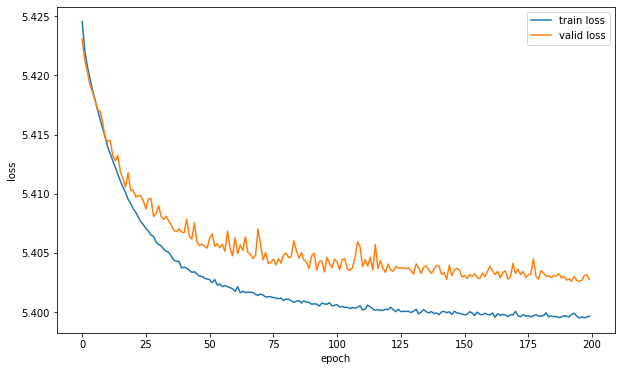

In [25]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

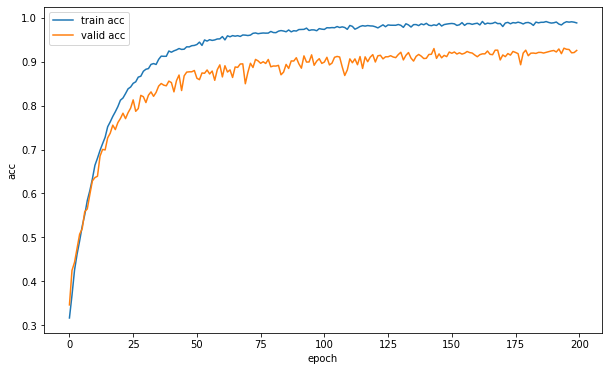

In [26]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('acc')